# Trajectory Testing Dev Portal #
_Purpose_: 
To generate testing tool kits for visualizing the trajectory generated by the MD simulation. (Possibly during the run time.  
<br/> 
_Requirement_:
First: Print Energy 
0. Print Energy (Total, Kinetic, Potential) 
1. Print Force
2. Generate plot of the energy running curve. 
3. Visualize the molecular geometry trajectory. 
<br/>

Second: Generate the Testing Documents
0. Generate Test Molecule 
<br/>


Third: 






In [1]:
import os
import sys 
import numpy as np
import pandas as pd 
import keras 
from Utils.DirNav import get_project_dir

from CompileCalc import CompileCalc
from CompileVecCalc import CompileVecCalc
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory

Using TensorFlow backend.


## Printing Functions 

In [2]:

def get_potential_energy_arr(traj):
    """Read the ase trajectory and plot the energy 
    
    """
    n_samples = len(traj)
    ke_arr = np.zeros(n_samples)
    pe_arr = np.zeros(n_samples)
    for i in np.arange(n_samples):
        ke_arr[i] = traj[i].get_potential_energy()
        pe_arr[i] = traj[i].get_kinetic_energy()
    
    return ke_arr, pe_arr

def print_md_energy(ke_arr_input, pe_arr_input, start_step):
    """Print the MD energy values from start_step
    
            Args:
                ke_arr_input: np.array of all the kinetic energy results. 
                pe_arr_input: np.array of all the potential energy results. 
                start_step: the step that started to display. All steps 
                            before are ignored. 
                            Used to ignored the initial steps for equilibrium. 
        
            Outputs:
                No. Plot the graph. 
            
    
    Comments: 
    ke and pe array should have the same size. 
    
    """
    
    
    n_samples = len(ke_arr_input)
    
    if start_step > n_samples:
        raise ValueError("print_md_energy: start_step is more than the md step")
    index_arr_input = np.arange(n_samples)
    index_arr = index_arr_input[start_step:-1]
    ke_arr = ke_arr_input[start_step:-1]
    pe_arr = pe_arr_input[start_step:-1]
    
    
    total_arr = ke_arr + pe_arr
    
    ke_fig = plt.figure()
    plt.plot(index_arr, ke_arr, label='Kinetic Energy (eV)')
    plt.legend()
    plt.xlabel("Step ")
    plt.ylabel("Energy (eV)")
    plt.show()
    
    pe_fig = plt.figure()
    plt.plot(index_arr, pe_arr, label='Potential Energy (eV)')
    plt.legend()
    plt.xlabel("Step ")
    plt.ylabel("Energy (eV)")
    plt.show()
    
    
    total_fig = plt.figure()
    plt.plot(index_arr, total_arr, label='Total Energy (eV)')
    plt.legend()
    plt.xlabel("Step ")
    plt.ylabel("Energy (eV)")
    plt.show()

In [3]:
project_dir = get_project_dir() 

In [4]:
glycine_opt_dir = os.path.join(project_dir, 'model', 'glycine_opt')
print(glycine_opt_dir)

/home/junmian/Applications/YeltsinNet/model/glycine_opt


## Molecular Dynamics Portal 

In [5]:
import importlib
#importlib.reload(CompileCalc)

In [7]:
#project_dir = get_project_dir()
#model_path = os.path.join(project_dir, 'model', 'dftb')
sys.path.append(project_dir)
from ase.md.verlet import VelocityVerlet
from ase import units
from ASEDFTBMod import DftbMod
os.environ['DFTB_PREFIX'] = '/home/junmian/Applications/dftbplus/mio-1-1/'
os.environ['DFTB_COMMAND'] = '/home/junmian/Applications/dftbplus/_install/bin/dftb+'

# Set path to the model

print(sys.path)

dftb_calc = DftbMod(
                     Hamiltonian_MaxAngularMomentum_='',
                     Hamiltonian_MaxAngularMomentum_O='"p"',
                     Hamiltonian_MaxAngularMomentum_H='"s"',
                     Hamiltonian_MaxAngularMomentum_C='"p"',
                     Hamiltonian_MaxAngularMomentum_N='"p"',
                     )

num_calc = CompileVecCalc(dftb_calc)
num_calc.import_model(glycine_opt_dir ,['H', 'O', 'N', 'C'], 'Gparam_dict.pkl')

from ase.io import read, write
#/md_sampling/example_molecules

glycine_test = read(os.path.join(project_dir, 'md_sampling','example_molecules' , 'glycine_opt.xyz'))
print(glycine_test.get_chemical_symbols())
num_calc.compile(glycine_test)

glycine_test.set_calculator(num_calc)

import YeltsinNet.src_nogrd as src_nogrd
glycine_at_map = src_nogrd.at_idx_map_generator(glycine_test)
print(glycine_at_map)

print("Analytical Force Calculation:")
print("Total Predicted Energy (eV)")
#import pdb; pdb.set_trace()
print(glycine_test.get_potential_energy())
print("Keras Energy Correction: (eV)")
print(glycine_test._calc.get_denergy())
print("Total Predicted Force: ")
print(glycine_test.get_forces())
print("Keras Delta Force")
print(glycine_test._calc.get_dforces())


# Set the momenta corresponding to T=300K
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
MaxwellBoltzmannDistribution(glycine_test, 300 * units.kB)

# # We want to run MD with constant energy using the VelocityVerlet algorithm.
# dyn = VelocityVerlet(glycine_test, 0.5 * units.fs)  # 5 fs time step.

# #Now run the dynamics
# for i in range(100):
#     dyn.run(1)




# Describe the interatomic interactions with the Effective Medium Theory
#glycine_test.set_calculator(anal_calc)
# Set the momenta corresponding to T=300K
#MaxwellBoltzmannDistribution(glycine_test, 300 * units.kB)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(glycine_test, 0.2 * units.fs)  # 5 fs time step.
traj = Trajectory('glycine_test.traj', 'w', glycine_test)
dyn.attach(traj.write)

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

    
printenergy(glycine_test)
for i in range(100):
    dyn.run(1)
    print("Step ", i)
    printenergy(glycine_test)

['', '/home/junmian/Applications/YeltsinNet/Calculator', '/home/junmian/Applications/YeltsinNet/YeltsinNet', '/home/junmian/Applications/YeltsinNet', '/home/junmian/Coding_Prac/ASE_ANI-master/lib', '/home/junmian/Applications/YeltsinNet/Calculator/dev', '/home/junmian/anaconda3/envs/tensorflow/lib/python36.zip', '/home/junmian/anaconda3/envs/tensorflow/lib/python3.6', '/home/junmian/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/junmian/.local/lib/python3.6/site-packages', '/home/junmian/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/junmian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/junmian/.ipython', '/home/junmian/Applications/YeltsinNet', '/home/junmian/Applications/YeltsinNet']
Successfully Imported the training model
['C', 'O', 'C', 'H', 'H', 'N', 'H', 'H', 'O', 'H']
{'H': array([3, 4, 6, 7, 9]), 'O': array([1, 8]), 'C': array([0, 2]), 'N': array([5])}
Analytical Force Calculation:
Total Predicted Energy (eV)
-7

Step  71
Energy per atom: Epot = -768.772eV  Ekin = 0.020eV (T=154K)  Etot = -768.752eV
Step  72
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=149K)  Etot = -768.752eV
Step  73
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=146K)  Etot = -768.752eV
Step  74
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=145K)  Etot = -768.752eV
Step  75
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=144K)  Etot = -768.752eV
Step  76
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=145K)  Etot = -768.752eV
Step  77
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=147K)  Etot = -768.752eV
Step  78
Energy per atom: Epot = -768.771eV  Ekin = 0.019eV (T=149K)  Etot = -768.752eV
Step  79
Energy per atom: Epot = -768.772eV  Ekin = 0.020eV (T=152K)  Etot = -768.752eV
Step  80
Energy per atom: Epot = -768.772eV  Ekin = 0.020eV (T=155K)  Etot = -768.752eV
Step  81
Energy per atom: Epot = -768.772eV  Ekin = 0.020eV (T=158K)  Etot = -768.752eV
Step  82
Energy per atom: Epot =

## Test All the Calculators 
Test all the calculators available to make sure that the result is accurate. 

* ModelCalc (Numerical Calculator) 
* SubNetCalc (Unoptimized Analytical Force Calculator, serve as benchmark)  
* CompileCalc (Optimized Analytical Force Calculator) 
* CompileVecCalc (Vectorized Analytical Force Calculator)

In [8]:
#from ModelCalc import ModelCalc

## Plot the Test Results (Test 1) 

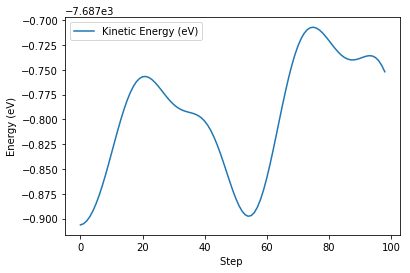

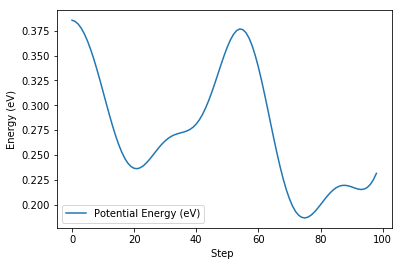

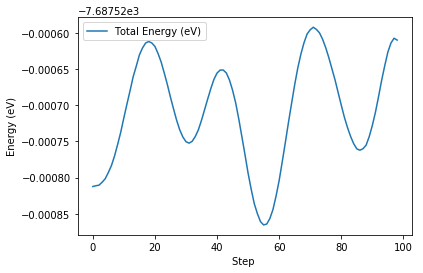

In [9]:
glycine_md_traj = Trajectory("glycine_test.traj", 'r')
ke_arr, pe_arr = get_potential_energy_arr(glycine_md_traj)
print_md_energy(ke_arr, pe_arr, 0)

## MD Test 2: 
Run 300 steps at once. 

In [10]:
model_path = os.path.join(project_dir, 'model', 'glycine_opt')
compile_calc = CompileVecCalc(dftb_calc)
compile_calc.import_model(model_path,['H', 'O', 'N', 'C'], 'Gparam_dict.pkl')

glycine_test_2 = read(os.path.join(project_dir, 'md_sampling', 'example_molecules' ,'glycine_opt.xyz'))

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
MaxwellBoltzmannDistribution(glycine_test_2, 300 * units.kB)

print(glycine_test_2.get_chemical_symbols())
compile_calc.compile(glycine_test)

glycine_test_2.set_calculator(compile_calc)

Successfully Imported the training model
['C', 'O', 'C', 'H', 'H', 'N', 'H', 'H', 'O', 'H']


In [11]:
dyn = VelocityVerlet(glycine_test_2, 0.1 * units.fs)  # 5 fs time step.
traj = Trajectory('glycine_test_2.traj', 'w', glycine_test_2)
dyn.attach(traj.write, interval=10)

printenergy(glycine_test)
dyn.run(300)

Energy per atom: Epot = -768.776eV  Ekin = 0.024eV (T=185K)  Etot = -768.752eV


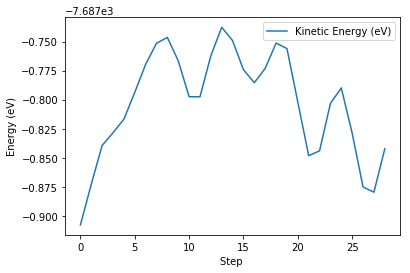

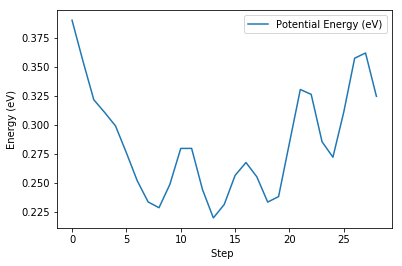

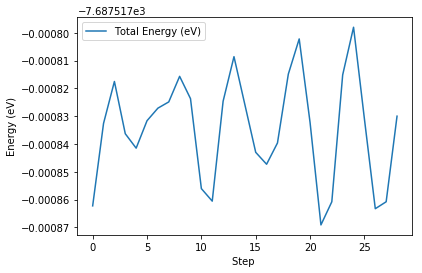

In [12]:
glycine_md_traj = Trajectory("glycine_test_2.traj", 'r')

ke_arr, pe_arr = get_potential_energy_arr(glycine_md_traj)
print_md_energy(ke_arr, pe_arr, 0)

## MD Test 3 
Run 2000 steps 

In [17]:
model_path = os.path.join(project_dir, 'model', 'glycine_opt')
compile_calc = CompileVecCalc(dftb_calc)
compile_calc.import_model(model_path,['H', 'O', 'N', 'C'], 'Gparam_dict.pkl')

glycine_test_3 = read(os.path.join(project_dir, 'md_sampling', 'example_molecules' ,'glycine_opt.xyz'))
print(glycine_test_3.get_chemical_symbols())
compile_calc.compile(glycine_test)

glycine_test_3.set_calculator(compile_calc)

Successfully Imported the training model
['C', 'O', 'C', 'H', 'H', 'N', 'H', 'H', 'O', 'H']


In [18]:
dyn = VelocityVerlet(glycine_test_3, 0.1 * units.fs)  # 5 fs time step.
traj = Trajectory('glycine_test_3.traj', 'w', glycine_test_3)
dyn.attach(traj.write, interval=10)

printenergy(glycine_test_3)
dyn.run(2000)

Energy per atom: Epot = -768.791eV  Ekin = 0.000eV (T=  0K)  Etot = -768.791eV


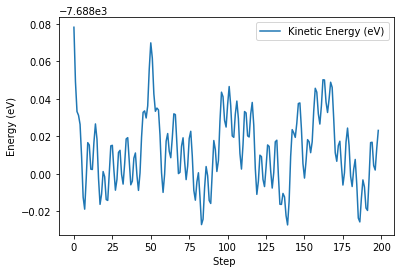

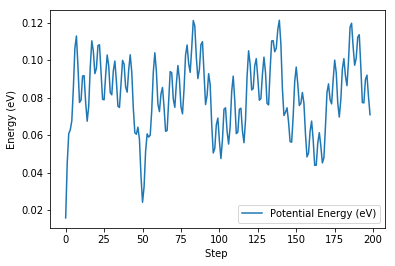

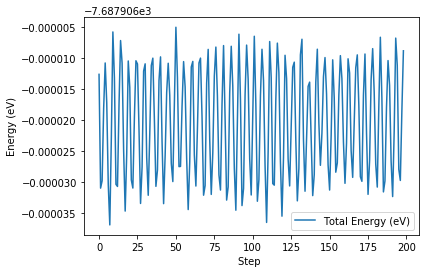

In [19]:
glycine_md_traj = Trajectory("glycine_test_3.traj", 'r')

ke_arr, pe_arr = get_potential_energy_arr(glycine_md_traj)
print_md_energy(ke_arr, pe_arr, 0)